In [5]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import Formatter, FixedLocator

In [ ]:
# Set up PPF scale for CDF plots
class PPFScale(mscale.ScaleBase):
    name = "ppf"

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self, axis)

    def get_transform(self):
        return self.PPFTransform()

    def set_default_locators_and_formatters(self, axis):
        class VarFormatter(Formatter):
            def __call__(self, x, pos=None):
                return f"{x}"[1:]

        axis.set_major_locator(FixedLocator(np.array([0,.0001,.001,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99,.999,.9999,1])))
        axis.set_major_formatter(VarFormatter())


    def limit_range_for_scale(self, vmin, vmax, minpos):
        return max(vmin, 1e-6), min(vmax, 1-1e-6)

    class PPFTransform(mtransforms.Transform):
        input_dims = output_dims = 1

        def ___init__(self, thresh):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            return stats.norm.ppf(a)

        def inverted(self):
            return PPFScale.IPPFTransform()

    class IPPFTransform(mtransforms.Transform):
        input_dims = output_dims = 1

        def transform_non_affine(self, a):
            return stats.norm.cdf(a)

        def inverted(self):
            return PPFScale.PPFTransform()

# Register PPF scale
mscale.register_scale(PPFScale)

# Set up fonts
# plt.rcParams["font.family"] = "arial"
plt.rcParams["font.size"] = 12

In [ ]:
# Load log file
names = ["chip", "time", "addr", "operation", "mask", "wl_dac_lvl", "bsl_dac_lvl", "sa_do", "ignore"]
formdata = pd.read_csv("../data/form.5mhz.188cell.csv", names=names, index_col=False)
formdata.sa_do = formdata.sa_do.shift(-1, fill_value=0)
formdata["nform"] = formdata.sa_do.apply(lambda di: bin(di).count("1"))
formdata = formdata[formdata.operation == "SET"]

# Figure
plt.figure(figsize=(5,3))
formdata[formdata.operation == "SET"].groupby("wl_dac_lvl").sum()["nform"].plot.bar(width=1)
plt.title("FORM-Inducing WL DAC Statistics (188x48 cells)")
plt.xlabel("WL DAC Level")
plt.ylabel("Frequency")
plt.text(100, 100, "bl_dac_lvl=31\nclk=5MHz\npw=3us\nread_dac_lvl=7\nclamp_ref_lvl=1\nform_thresh=32")
plt.locator_params(nbins=10)
plt.tight_layout()
plt.savefig("figs/form.wl.stats.pdf")

In [ ]:
# Load log file
names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
formreaddata = pd.read_csv("../data/formread.5mhz.188cell.csv", names=names, index_col=False, delimiter="\t")

# Figure
plt.figure(figsize=(5,3))
plt.bar(np.arange(2, 64, 4), np.bincount(formreaddata[formreaddata.columns[-48:]].values.flatten()), width=4)
plt.title("Post-FORM READ Statistics (188x48 cells)")
plt.xlabel("READ Ref Level")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figs/form.read.stats.pdf")

In [ ]:
# Produce checkerboard plots for 1-4 bpc
confmats = []
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(5,4))
for bpc in range(1, 5):
  # Subplot
  plt.subplot(220 + bpc)

  # Load data
  names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
  data = pd.read_csv(f"../data/{bpc}bpc.csv", sep="\t", names=names)

  # Show multi-bit result
  matdata = data[data.columns[-48:]].values[:48]
  im = plt.imshow(matdata, vmin=0, vmax=2**bpc-1)
  cbar = plt.colorbar(im, fraction=0.04, pad=0.04)
  if bpc != 4:
    cbar.set_ticks(range(2**bpc))
  # cbar.set_label("READ Value")
  plt.title(f"{bpc}bpc", x=0.5, y=0.5, verticalalignment="center", horizontalalignment="center", backgroundcolor="white", fontweight="bold")
  if bpc > 2:
    plt.xlabel("Bit Index")
  if bpc % 2 == 1:
    plt.ylabel("Address")

  # Load data into confmat
  confmat = np.zeros(shape=(2**bpc, 2**bpc))
  for i in range(48):
    for j in range(48):
      confmat[(data["addr"][i] + j) % (2**bpc)][matdata[i][j]] += 1
  confmat = confmat.astype(int)
  print(confmat)

  # Symbol error magnitudes
  mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
  rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

  # Function to get Gray code string
  getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

  # Function to get Gray code error rate for each possible symbol confusion
  grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc
  # print(grayerr)

  # BER
  ber = (grayerr * confmat).sum() / confmat.sum()
  plt.text(0.5*48, 0.7*48, f"Gray BER = " + format(ber*100, ".2f") + "%\nLinear RMSE = " + format(rmse, ".2f"), fontsize=8, verticalalignment="center", horizontalalignment="center", backgroundcolor="white")

  # Set ticks
  plt.xticks([0,16,32,47])
  plt.yticks([0,16,32,47])
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.5)
plt.tight_layout()
plt.savefig(f"figs/cb.pdf")
plt.show()

def binary_to_gray_op(n):
  n = int(n, 2)
  n ^= (n >> 1)
  return bin(n)[2:]

In [ ]:
# Plot conductance ranges
import json
settings = json.load(open("../settings/2bpc.json"))
plt.axvline(0, 0, 1, color='r')
for level in settings["level_settings"]:
    plt.axvline(level["adc_upper_read_ref_lvl"], 0, 1, color='r')
    plt.axvline(level["adc_lower_write_ref_lvl"], 0, 0.5, color='g', linestyle='--')
    plt.axvline(level["adc_upper_write_ref_lvl"], 0, 0.5, color='g', linestyle='--')
plt.xlim(-0.5, 63.5)
plt.gca().get_yaxis().set_visible(False)

In [ ]:
names = ["addr", "i", "Cycle #", "RESET", "SET"]
data = pd.read_csv(f"../data/endurance.csv.gz", delimiter='\t', names=names)
data = data[data["addr"] == 10900]
data = data[data["i"] == 9]
plt.rcParams["figure.figsize"] = (5,3)
data.groupby("i").plot("Cycle #", ["SET", "RESET"], title="Endurance Cycling Behavior", ylabel="ADC Level")
plt.tight_layout()
plt.savefig("figs/endurance.pdf")
plt.show()

In [ ]:
# Load retention time data
tdata = pd.read_csv("../data/retention2.min.csv.gz")
tdata

In [ ]:
# Plot sigma-mu
%matplotlib inline
times = [0, 0.1, 1, 10, 100, 1000, 10000, 100000]
for time in times:
    sbadata = tdata[(tdata["timept"] == time) & tdata["lvli"].isin(range(0,64,1))].groupby("lvli")["lvl"].std()
    sbadata.plot(label=f"data,t={time}")
    fit = np.polyfit(sbadata.index.values, sbadata.values, 3)
    print(np.poly1d(fit))
    plt.plot(range(4,64), np.poly1d(fit)(range(4,64)), '--', label=f"fit,t={time}")
plt.title("Sigma-Mu Plot for SBA")
plt.xlabel("Programmed Level")
plt.ylabel("Stdev. of READ Level")
# plt.legend()
plt.tight_layout()
plt.savefig("figs/sigmamu.pdf")
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [9, 4]
tdata.groupby("lvli").count()["lvl"].plot.bar()
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
# Show distribution
time = 100
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (1024 cells w/64 levels, ~3hrs)")
d = tdata[(tdata["timept"] == time) & tdata["lvli"].isin(range(0,64,1))]
for i in range(64):
    rdata = d[d["lvli"] == i]
    if len(rdata) != 0:
        plt.plot(sorted(rdata["lvl"].values), np.linspace(0+1/len(rdata), 1-1/len(rdata), len(rdata)), label=i)
plt.xlabel("Programmed Level")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 64)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()



In [22]:
# Set VDDIO (times 10)
vddio = 25

In [23]:
# SET sweep data
setdata = pd.read_csv(f"../data/setsweep{vddio}.csv", delimiter="\t", names=["addr", "t", "vwl", "vbl", "pw"] + [f"gi[{i}]" for i in range(16)] + [f"gf[{i}]" for i in range(16)])
setdata = pd.concat([setdata[["addr","t","vwl","vbl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(16)])
setdata

,addr,t,vwl,vbl,pw,gi,gf
0,58881,1.685559e+09,0,0,1,6,6
1,58292,1.685559e+09,0,4,1,9,9
2,30216,1.685559e+09,0,8,1,4,4
3,44022,1.685559e+09,0,12,1,5,4
4,43578,1.685559e+09,0,16,1,5,31
...,...,...,...,...,...,...,...
136825,22753,1.685598e+09,226,8,16,35,37
136826,50171,1.685598e+09,226,12,16,30,38
136827,21265,1.685598e+09,226,16,16,5,42
136828,6292,1.685598e+09,226,20,16,7,49


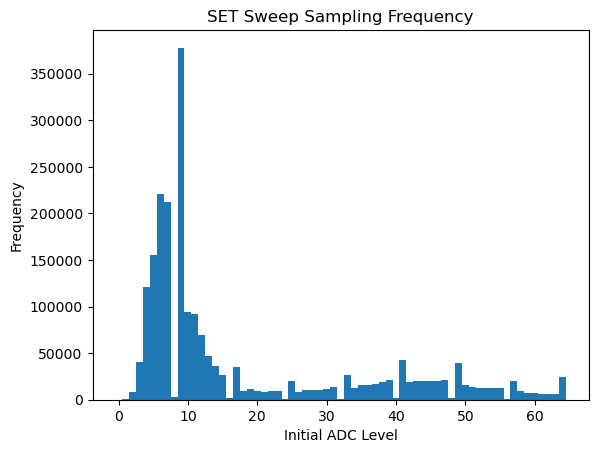

In [24]:
setdata["gi"].plot.hist(bins=np.arange(-0.5, 65.5))
plt.title("SET Sweep Sampling Frequency")
plt.xlabel("Initial ADC Level")
plt.show()

In [ ]:
for pw in setdata["pw"].unique():
    d = setdata[(setdata["gi"].isin(range(5,9))) & (setdata["pw"] == pw)][["vwl","vbl","pw","gf"]]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"SET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("BL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Final ADC Level")
    ax.set_zlim(0, 64)
    ax.view_init(elev=7, azim=-26)
    ax.scatter3D(d['vbl'], d['vwl'], d['gf'], c=d['vbl'])
    plt.savefig(f"figs/set_sweep_{vddio}_{str(pw).zfill(4)}.png", dpi=300)

In [ ]:
for pw in setdata["pw"].unique():
    setdatamean = setdata[(setdata["gi"].isin(range(5,9))) & (setdata["pw"] == pw)].groupby(["vwl","vbl","pw"])["gf"].mean().reset_index()
    d = setdatamean[setdatamean["pw"] == pw]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"SET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("BL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Mean Final ADC Level")
    ax.set_zlim(0, 64)
    ax.view_init(elev=7, azim=-26)
    ax.plot_trisurf(d['vbl'], d['vwl'], d['gf'], label=f"pw={pw}")
    plt.savefig(f"figs/set_sweep_{vddio}_mean_{str(pw).zfill(4)}.png", dpi=300)

    setdatastd = setdata[(setdata["gi"].isin(range(5,9))) & (setdata["pw"] == pw)].groupby(["vwl","vbl","pw"])["gf"].std().reset_index()
    d = setdatastd[setdatastd["pw"] == pw]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"SET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("BL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Stdev. Final ADC Level")
    ax.set_zlim(0, 8)
    ax.view_init(elev=7, azim=-26)
    ax.plot_trisurf(d['vbl'], d['vwl'], d['gf'], label=f"pw={pw}")
    plt.savefig(f"figs/set_sweep_{vddio}_std_{str(pw).zfill(4)}.png", dpi=300)

In [ ]:
# Reset sweep data
resetdata = pd.read_csv(f"../data/resetsweep{vddio}.csv", delimiter="\t", names=["addr", "t", "vwl", "vsl", "pw"] + [f"gi[{i}]" for i in range(16)] + [f"gf[{i}]" for i in range(16)])
resetdata = pd.concat([resetdata[["addr","t","vwl","vsl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(16)])
resetdata

In [ ]:
plt.figure()
resetdata["gi"].plot.hist(bins=np.arange(-0.5, 65.5))
plt.title("RESET Sweep Sampling Frequency")
plt.xlabel("Initial ADC Level")
plt.show()

In [ ]:
for pw in resetdata["pw"].unique():
    d = resetdata[(resetdata["gi"].isin(range(55,59))) & (resetdata["pw"] == pw)][["vwl","vsl","pw","gf"]]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"RESET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("SL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Final ADC Level")
    ax.set_zlim(0, 64)
    ax.view_init(elev=21, azim=42)
    ax.scatter3D(d['vsl'], d['vwl'], d['gf'], c=d['vsl'])
    plt.savefig(f"figs/reset_sweep_{vddio}_{str(pw).zfill(4)}.png", dpi=300)

In [ ]:
for pw in resetdata["pw"].unique():
    resetdatamean = resetdata[(resetdata["gi"].isin(range(55,59))) & (resetdata["pw"] == pw)].groupby(["vwl","vsl","pw"])["gf"].mean().reset_index()
    d = resetdatamean[resetdatamean["pw"] == pw]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"RESET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("SL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Mean Final ADC Level")
    ax.set_zlim(0, 64)
    ax.view_init(elev=21, azim=42)
    ax.plot_trisurf(d['vsl'], d['vwl'], d['gf'], label=f"pw={pw}")
    plt.savefig(f"figs/reset_sweep_{vddio}_mean_{str(pw).zfill(4)}.png", dpi=300)
    
    resetdatastd = resetdata[(resetdata["gi"].isin(range(55,59))) & (resetdata["pw"] == pw)].groupby(["vwl","vsl","pw"])["gf"].std().reset_index()
    d = resetdatastd[resetdatastd["pw"] == pw]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"RESET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("SL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Stdev. Final ADC Level")
    ax.set_zlim(0, 12)
    ax.view_init(elev=21, azim=42)
    ax.plot_trisurf(d['vsl'], d['vwl'], d['gf'], label=f"pw={pw}")
    plt.savefig(f"figs/reset_sweep_{vddio}_std_{str(pw).zfill(4)}.png", dpi=300)


In [43]:
# Load data
vs = ["vdd", "vdd_dac", "vsa", "vddio", "vddio_dac"]
edata = pd.read_csv("../setenergy33_baseline_v2.csv", delimiter="\t", names=["time", "vwl", "vbl", "pw", "i(vdd)", "i(vdd_dac)", "i(vsa)", "i(vddio)", "i(vddio_dac)", "v(vddio)", "v(vddio_dac)"])
edata["v(vdd)"] = edata["v(vdd_dac)"] = edata["v(vsa)"] = 0.9
for v in vs:
  edata[f"p({v})"] = edata[f"v({v})"] * edata[f"i({v})"]
edata["totpow"] = sum([edata[f"p({v})"] for v in vs])
edata

,time,vwl,vbl,pw,i(vdd),i(vdd_dac),i(vsa),i(vddio),i(vddio_dac),v(vddio),v(vddio_dac),v(vdd),v(vdd_dac),v(vsa),p(vdd),p(vdd_dac),p(vsa),p(vddio),p(vddio_dac),totpow
0,1.686546e+09,0,0,3968,0.000090,0.000092,0.000062,0.003776,0.000431,3.30008,3.30098,0.9,0.9,0.9,0.000081,0.000083,0.000056,0.012462,0.001424,0.014105
1,1.686546e+09,0,4,3968,0.000089,0.000091,0.000062,0.004675,0.000451,3.30008,3.30098,0.9,0.9,0.9,0.000080,0.000082,0.000056,0.015427,0.001489,0.017134
2,1.686546e+09,0,8,3968,0.000090,0.000092,0.000062,0.005363,0.000471,3.30008,3.30098,0.9,0.9,0.9,0.000081,0.000082,0.000056,0.017698,0.001554,0.019471
3,1.686546e+09,0,12,3968,0.000089,0.000091,0.000062,0.005924,0.000481,3.30008,3.30098,0.9,0.9,0.9,0.000080,0.000082,0.000056,0.019549,0.001588,0.021355
4,1.686546e+09,0,16,3968,0.000089,0.000091,0.000062,0.006110,0.000485,3.30008,3.30098,0.9,0.9,0.9,0.000080,0.000082,0.000056,0.020163,0.001601,0.021981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,1.686546e+09,144,28,3968,0.000089,0.000091,0.000062,0.007481,0.000516,3.30008,3.30098,0.9,0.9,0.9,0.000080,0.000082,0.000056,0.024687,0.001703,0.026608
89,1.686546e+09,144,31,3968,0.000090,0.000092,0.000062,0.008424,0.000529,3.30008,3.30098,0.9,0.9,0.9,0.000081,0.000082,0.000056,0.027799,0.001746,0.029764
90,1.686546e+09,160,0,3968,0.000089,0.000091,0.000062,0.003453,0.000422,3.30008,3.30098,0.9,0.9,0.9,0.000080,0.000082,0.000056,0.011396,0.001394,0.013009
91,1.686546e+09,160,4,3968,0.000089,0.000091,0.000062,0.004648,0.000451,3.30008,3.30098,0.9,0.9,0.9,0.000080,0.000082,0.000056,0.015339,0.001488,0.017044


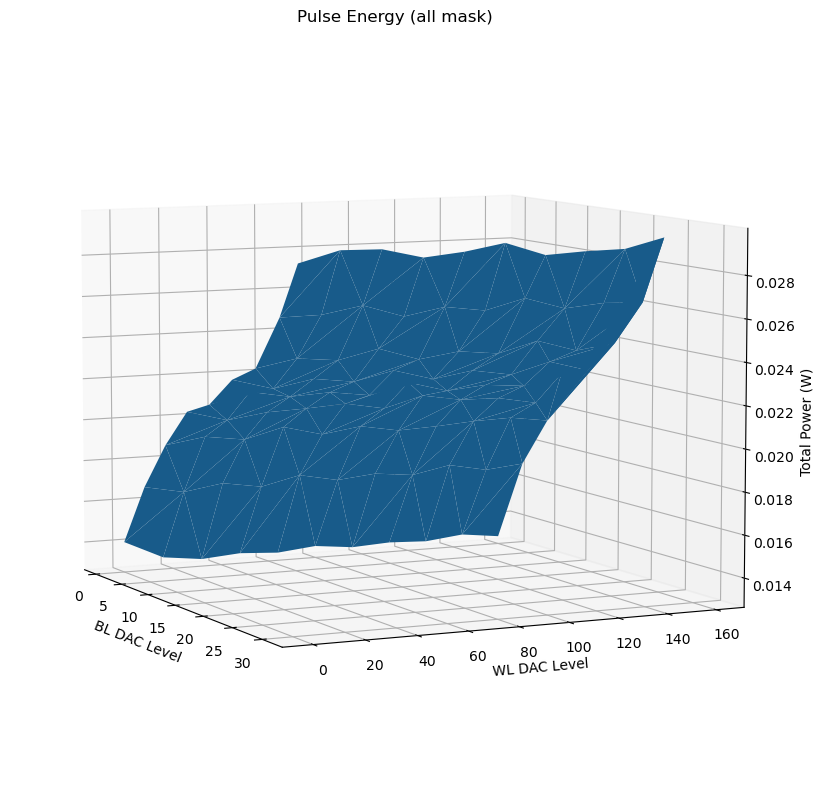

In [44]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_title(f"Pulse Energy (all mask)")
ax.set_xlabel("BL DAC Level")
ax.set_ylabel("WL DAC Level")
ax.set_zlabel("Total Power (W)")
# ax.set_zlim(0, 8)
ax.view_init(elev=7, azim=-26)
ax.plot_trisurf(edata['vbl'], edata['vwl'], edata['totpow'])
plt.show()